<a href="https://colab.research.google.com/github/AlessioLampis/HomeworkOne/blob/master/Urbansound8k_first_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Connect the google drive account and loads the urbansound8k data in google colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Sound classification

In [3]:
#Import all basic libraries
import numpy as np
import pandas as pd
import os
import os.path
import struct
import time
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython as IP
import IPython.display as ipd

#Import libraries used to built the model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from datetime import datetime 

Using TensorFlow backend.


## Data analysis

In [0]:
#Set the path to the original dataset
us8k_path = 'gdrive/My Drive/urbansound8k'

# Global settings
metadata_path = us8k_path + '/UrbanSound8K.csv'

In [5]:
# Load metadata as a Pandas dataframe
metadata = pd.read_csv(metadata_path)

# Examine dataframe's head
metadata.head()

slice_file_name    fsID  start  ...  fold  classID             class
0    100032-3-0-0.wav  100032    0.0  ...     5        3          dog_bark
1  100263-2-0-117.wav  100263   58.5  ...     5        2  children_playing
2  100263-2-0-121.wav  100263   60.5  ...     5        2  children_playing
3  100263-2-0-126.wav  100263   63.0  ...     5        2  children_playing
4  100263-2-0-137.wav  100263   68.5  ...     5        2  children_playing

[5 rows x 8 columns]

In [6]:
# Class distribution
metadata['class'].value_counts()

children_playing    1000
jackhammer          1000
engine_idling       1000
air_conditioner     1000
drilling            1000
dog_bark            1000
street_music        1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

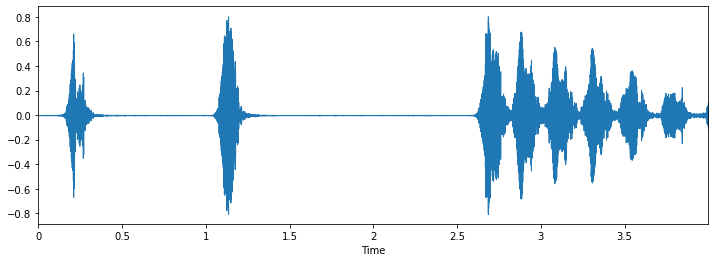

In [7]:
# Taking a look and listen at an audio example for each class

# dog_bark
filename = us8k_path + '/fold1/101415-3-0-2.wav' 
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

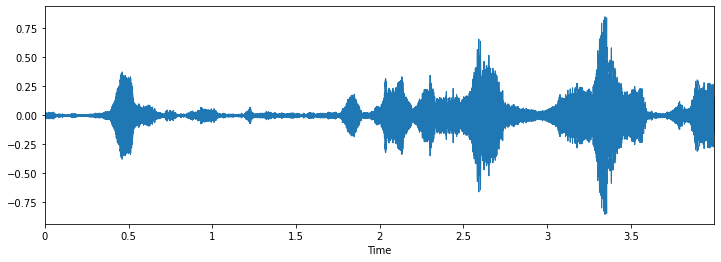

In [8]:
# children_playing
filename = us8k_path + '/fold10/101382-2-0-21.wav'
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

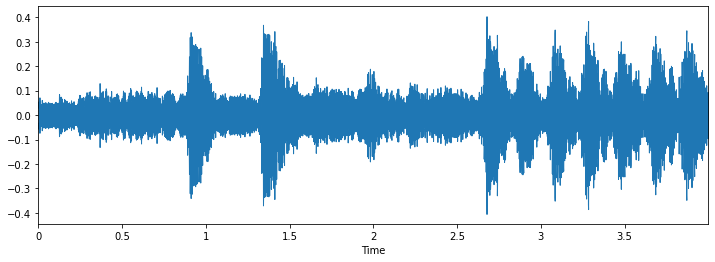

In [9]:
# street_music
filename = us8k_path + '/fold3/182103-9-0-26.wav' 
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

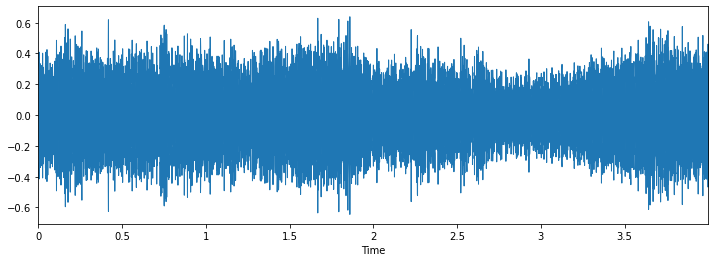

In [10]:
# drilling
filename = us8k_path + '/fold3/103199-4-2-7.wav' 
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

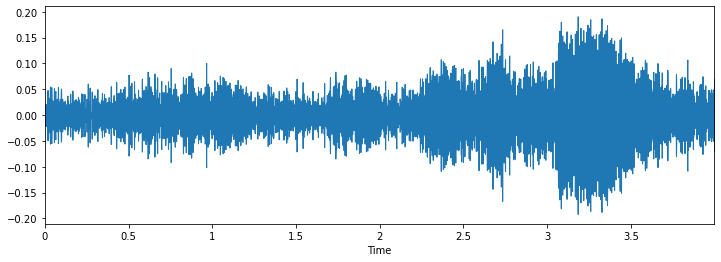

In [11]:
# air_conditioner
filename = us8k_path + '/fold6/184805-0-0-49.wav' 
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

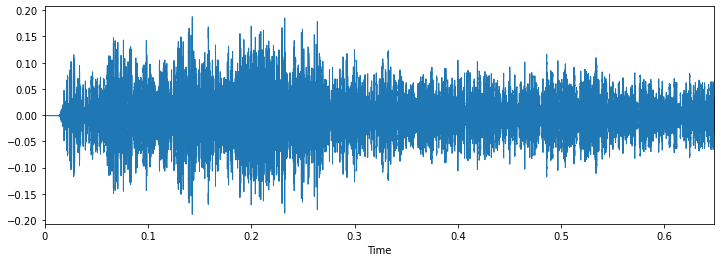

In [12]:
# car_horn
filename = us8k_path + '/fold10/100648-1-0-0.wav'  
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

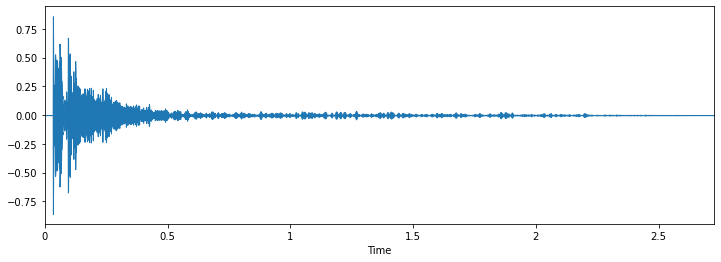

In [13]:
# gun_shot
filename = us8k_path + '/fold7/7067-6-0-0.wav'   
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

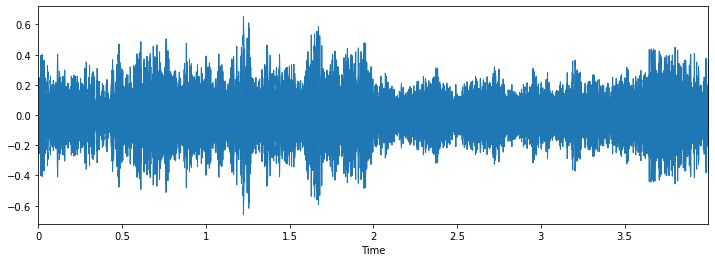

In [14]:
# siren
filename = us8k_path + '/fold8/71177-8-1-3.wav'  
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename) 

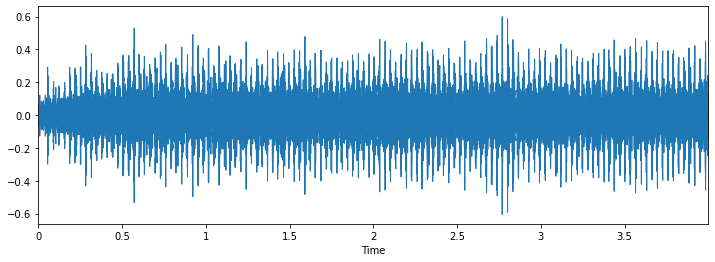

In [15]:
# jackhammer
filename = us8k_path + '/fold2/73623-7-3-0.wav' 
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename) 

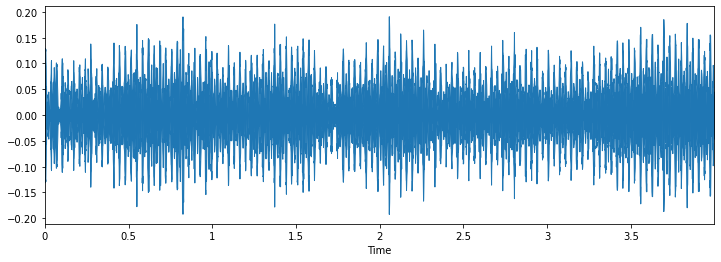

In [16]:
# engine_idling
filename = us8k_path + '/fold5/106487-5-0-0.wav'
ipd.Audio(filename)
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename) 

##Code for the extraction of the audios properties

In [17]:
 !pip install soundfile

In [0]:
import soundfile as sf
def audio_properties(filename):
  audio= sf.SoundFile(filename)
  sample_rate = audio.samplerate
  num_channels = audio.channels
  bit_depth = audio.subtype
  return (num_channels,sample_rate,bit_depth)

audiodata = []
for index, row in metadata.iterrows():
    
    file_name =  us8k_path + '/' + 'fold'+ str(row["fold"]) + '/' + str(row["slice_file_name"])
    data = audio_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [19]:
audiodf.head()
# PCM_16 means 16 bit depth, where PCM stands for Pulse-Code Modulation.

num_channels  sample_rate bit_depth
0             2        44100    PCM_16
1             2        44100    PCM_16
2             2        44100    PCM_16
3             2        44100    PCM_16
4             2        44100    PCM_16

In [20]:
# number of channels 

print(audiodf.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


In [21]:
# sample rates 

print(audiodf.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


In [22]:
# bit depth

print(audiodf.bit_depth.value_counts(normalize=True))

PCM_16       0.659414
PCM_24       0.315277
FLOAT        0.019354
PCM_U8       0.004924
MS_ADPCM     0.000916
IMA_ADPCM    0.000115
Name: bit_depth, dtype: float64


## Extracting the features

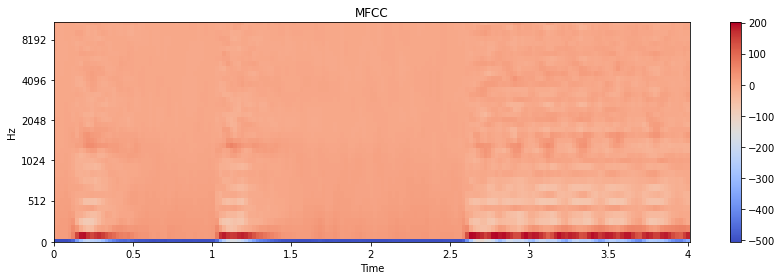

In [23]:
# Extracting the MFCC of a single audio example
y, sr = librosa.load(us8k_path + '/' + 'fold1'+ '/' + '101415-3-0-2.wav', res_type='kaiser_fast')
normalized_y = librosa.util.normalize(y)
mfcc = librosa.feature.mfcc(normalized_y, sr, n_mfcc=40)
#mfcc = np.mean(mfcc.T,axis=0)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc,x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [0]:
def extract_features(file_name):

        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T,axis=0)
       	return mfccs_scaled

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():    
    file_name = us8k_path + '/' + 'fold'+ str(row["fold"]) + '/' + str(row["slice_file_name"])
    class_label = row["class"]
    fold = row["fold"]
    data = extract_features(file_name)
    features.append([data, class_label,fold])
      #print("extracting from folder 1")
    

    

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label','fold'])

In [25]:
featuresdf.head()

feature       class_label  fold
0  [-215.79300197978586, 71.6661218577675, -131.8...          dog_bark     5
1  [-424.6868571740465, 110.56227614968267, -54.1...  children_playing     5
2  [-459.56466281715973, 122.80034862683685, -47....  children_playing     5
3  [-414.5537705356148, 102.896905432003, -36.664...  children_playing     5
4  [-447.3969992817084, 115.09538477641466, -53.8...  children_playing     5

##Preparing the testing and training data

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.1, random_state = 42)


##Building the model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [0]:

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [29]:

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

##Fitting the model

In [30]:

from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath= us8k_path + '/saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 7858 samples, validate on 874 samples
Epoch 1/72
7858/7858 [==============================] - 0s 47us/step - loss: 21.2863 - accuracy: 0.1565 - val_loss: 2.0185 - val_accuracy: 0.3330

Epoch 00001: val_loss improved from inf to 2.01849, saving model to gdrive/My Drive/urbansound8k/saved_models/weights.best.basic_mlp.hdf5
Epoch 2/72
7858/7858 [==============================] - 0s 30us/step - loss: 5.0004 - accuracy: 0.2217 - val_loss: 2.0876 - val_accuracy: 0.2895

Epoch 00002: val_loss did not improve from 2.01849
Epoch 3/72
7858/7858 [==============================] - 0s 29us/step - loss: 2.7150 - accuracy: 0.2210 - val_loss: 2.1658 - val_accuracy: 0.1602

Epoch 00003: val_loss did not improve from 2.01849
Epoch 4/72
7858/7858 [==============================] - 0s 32us/step - loss: 2.3596 - accuracy: 0.2252 - val_loss: 2.1543 - val_accuracy: 0.1991

Epoch 00004: val_loss did not improve from 2.01849
Epoch 5/72
7858/7858 [==============================] - 0s 28us/step - loss: 

##Evaluation of the model

In [31]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8699414730072021
Testing Accuracy:  0.8329519629478455


##Confusion matrix

In [32]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(x_test)
confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))


array([[ 88,   0,   3,   0,   0,   0,   0,   3,   0,   4],
       [  0,  30,   1,   0,   0,   2,   0,   0,   0,   4],
       [  5,   0,  79,   3,   1,   3,   0,   0,   1,   8],
       [  2,   0,  11,  74,   0,   2,   2,   1,   2,   5],
       [  1,   0,   4,   4,  87,   0,   0,   3,   0,   9],
       [  4,   0,   2,   0,   0,  88,   0,   0,   1,   1],
       [  1,   0,   2,   4,   0,   1,  24,   1,   0,   1],
       [  0,   0,   0,   0,   4,   0,   0, 101,   0,   0],
       [  0,   0,   3,   2,   0,   0,   0,   1,  80,   0],
       [  7,   0,  13,   4,   3,   4,   0,   1,   2,  77]])